In [4]:
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import label_binarize

output_fold = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/results/ML_results'
if not os.path.exists(output_fold):
    os.makedirs(output_fold)


def get_metrics(y_true, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # 明确指定labels参数
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # 现在cm是一个2x2矩阵，即使数据只包含一个类别
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_true, y_pred)

    return accuracy, sensitivity, specificity, f1


res = {}

# 初始化模型，同时设置随机种子
models = {
    # "Logistic Regression": LogisticRegression(max_iter=150),
    "Decision Tree": DecisionTreeClassifier()
}

def pre_post_read_hb_label(HB_TYPE, combine_type, fold='./allData/prognosis/DMFC/pre_post_treatment_hamd_reduction_50'):
    # read data 
    hb = np.load(fold + '/data.npy')
    label = np.load(fold + '/label.npy')
    # Delete NaN values from hb
    hb = np.nan_to_num(hb)
    
    if HB_TYPE == 'HbO':
        hb1 = hb[..., 0, 0]
        hb2 = hb[..., 0, 1]
    elif HB_TYPE == 'HbR':
        hb1 = hb[..., 1, 0]
        hb2 = hb[..., 1, 1]
    elif HB_TYPE == 'HbT':
        hb1 = hb[..., 2, 0]
        hb2 = hb[..., 2, 1]
    if combine_type == 'substract':
        hb = hb2 - hb1
        
    hb_2d = np.reshape(hb, (hb.shape[0], -1))
    return hb_2d, label


for name, model in models.items():
    # run multiple time, using different time stamp as random seed
    for num_time in range(1):
        print(f'current training {name}, num_time: {num_time}')

        # 使用当前时间戳作为随机种子
        current_time_seed = 1706258708

        # build model
        model.random_state = current_time_seed

        hb_result = {}
        HB_TYPE_accuraies = {}
        HB_TYPE_y_pred_and_y_test = {}
        for HB_TYPE in ['HbR']:
            HB_TYPE_accuraies[HB_TYPE] = []
            HB_TYPE_y_pred_and_y_test[HB_TYPE] = []

            # read data
            fold = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/DMFC/pre_post_treatment_hamd_reduction_50'

            hb_2d, label = pre_post_read_hb_label(HB_TYPE, 'substract', fold)

            # Apply LOOCV to train the model
            # Initialize LeaveOneOut
            loo = LeaveOneOut()

            # 存储每个模型的准确率
            accuracies = {}

            # Loop over each train/test split
            for train_index, test_index in loo.split(hb_2d):
                # Split the data into training and testing sets
                X_train, X_test = hb_2d[train_index], hb_2d[test_index]
                y_train, y_test = label[train_index], label[test_index]

                # Train the classifier
                model.fit(X_train, y_train)

                # Predict the label for the test set
                y_pred = model.predict(X_test)

                # Calculate the accuracy for the current fold
                accuracy = accuracy_score(y_test, y_pred)

                # Append the accuracy to the list
                HB_TYPE_accuraies[HB_TYPE].append(accuracy)

                HB_TYPE_y_pred_and_y_test[HB_TYPE].append([y_pred, y_test])
            accuracies[HB_TYPE] = 1
            accuracies[HB_TYPE] = np.mean(HB_TYPE_accuraies[HB_TYPE])

        save_result = {}
        save_result['accuracies'] = accuracies
        save_result['model_accuraies'] = HB_TYPE_accuraies
        save_result['current_time_seed'] = current_time_seed
        save_result['num_time'] = num_time
        save_result['HB_TYPE_y_pred_and_y_test'] = HB_TYPE_y_pred_and_y_test

        res[f'{num_time}'] = save_result
    # np.save(output_fold + f'/{name}_result_validate.npy', res)

current training Decision Tree, num_time: 0


(2704,)
0.0003698224852071006
ch1: 1, ch2: 38
ch1: 22, ch2: 47
ch1: 25, ch2: 33


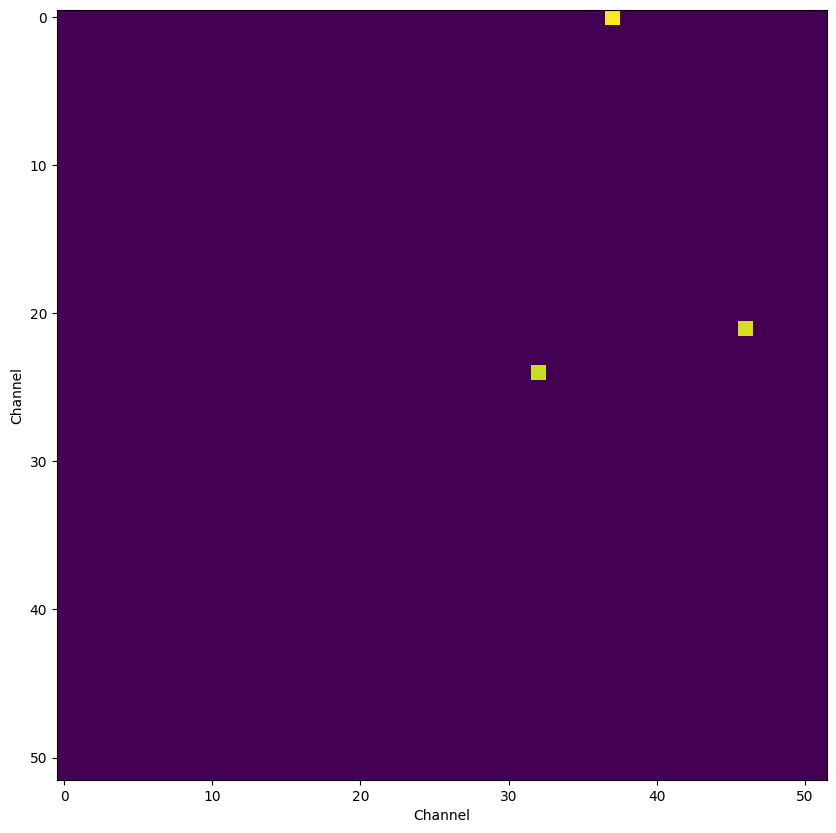

In [11]:
save_result['accuracies']
feature_importances = model.feature_importances_
print(feature_importances.shape)
plt.figure(figsize=(10, 10))
feature_importances_2d = np.reshape(feature_importances, (52, 52))
plt.imshow(feature_importances_2d)
plt.xlabel('Channel')
plt.ylabel('Channel')
mean_feature_importances = np.mean(feature_importances)
print(mean_feature_importances)

for ch_1 in range(52):
    for ch_2 in range(52):
        if feature_importances_2d[ch_1, ch_2] > mean_feature_importances:
            print(f'ch1: {ch_1+1}, ch2: {ch_2+1}')